<a href="https://colab.research.google.com/github/ABD-01/Face-Unlock/blob/master/FaceNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import glob
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from itertools import combinations 
from collections import OrderedDict
from tqdm import tqdm #, tqdm_notebook
from tqdm.notebook import tqdm as tqdm_notebook
 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

import torchvision
import torchvision.transforms as transforms

from typing import Callable, Optional
from  torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [2]:
torch.cuda.is_available()

False

In [3]:
def seed_init():
    np.random.seed(0)
    random.seed(0)
    torch.manual_seed(0)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(0)
        torch.cuda.manual_seed_all(0)
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_init()
# ref : https://discuss.pytorch.org/t/random-seed-initialization/7854/19


In [48]:
PATH = '/content/drive/MyDrive/Colab Notebooks/att_face_dataset/'

In [53]:
def pil_loader(path: str) -> Image.Image:
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert()

class AttDataset(ImageFolder):

    def __init__(
        self,
        path: str,
        transform: Optional[Callable] = ToTensor()
    ):
        super(AttDataset, self).__init__(path,transform, loader=pil_loader)

# ref: https://pytorch.org/vision/stable/_modules/torchvision/datasets/folder.html#ImageFolder

In [54]:
process = transforms.Compose([
    transforms.Resize((224,224), interpolation= transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=0.4422, std=0.1931),
])

In [59]:
dataset = AttDataset(PATH, transform=process)
dataset

Dataset AttDataset
    Number of datapoints: 400
    Root location: /content/drive/MyDrive/Colab Notebooks/att_face_dataset/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bicubic)
               ToTensor()
               Normalize(mean=0.4422, std=0.1931)
           )

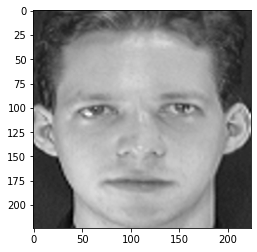

In [61]:
plt.imshow(dataset[0][0].squeeze(), cmap='gray')

In [76]:
t = torch.randn(4,5)
t

tensor([[ 0.0127, -0.7324,  0.5727,  0.7141,  0.7940],
        [-1.3962, -0.4494,  1.1166, -0.5309,  1.5457],
        [ 1.3264, -0.4194, -1.8764,  0.1081,  1.2119],
        [ 0.1974, -2.8361, -0.0928,  1.4823, -0.3664]])

In [4]:
torch.transpose(t, 0,1)

tensor([[0.7580, 0.2591, 0.7050, 0.7384],
        [0.3276, 0.9551, 0.8208, 0.8103],
        [0.6358, 0.6649, 0.6041, 0.8570],
        [0.1005, 0.7192, 0.2275, 0.3516],
        [0.2917, 0.2577, 0.6584, 0.2809]])

In [5]:
t.T

tensor([[0.7580, 0.2591, 0.7050, 0.7384],
        [0.3276, 0.9551, 0.8208, 0.8103],
        [0.6358, 0.6649, 0.6041, 0.8570],
        [0.1005, 0.7192, 0.2275, 0.3516],
        [0.2917, 0.2577, 0.6584, 0.2809]])

In [19]:
dp = torch.matmul(t, t.T)
dp

tensor([[1.1813, 1.0795, 1.4023, 1.4873],
        [1.0795, 2.0051, 1.7015, 1.8603],
        [1.4023, 1.7015, 2.0209, 1.9683],
        [1.4873, 1.8603, 1.9683, 2.1388]])

In [21]:
d = dp.diag()
d, d.shape

(tensor([1.1813, 2.0051, 2.0209, 2.1388]), torch.Size([4]))

In [23]:
d.unsqueeze(0).shape, d.unsqueeze(1).shape

(torch.Size([1, 4]), torch.Size([4, 1]))

In [24]:
d.unsqueeze(0) + dp + d.unsqueeze(1)

tensor([[3.5439, 4.2659, 4.6045, 4.8074],
        [4.2659, 6.0153, 5.7275, 6.0042],
        [4.6045, 5.7275, 6.0626, 6.1280],
        [4.8074, 6.0042, 6.1280, 6.4163]])

In [68]:
t.maximum(0)

TypeError: ignored

In [34]:
torch.maximum(t, torch.tensor(0.5))

tensor([[0.7580, 0.5000, 0.6358, 0.5000, 0.5000],
        [0.5000, 0.9551, 0.6649, 0.7192, 0.5000],
        [0.7050, 0.8208, 0.6041, 0.5000, 0.6584],
        [0.7384, 0.8103, 0.8570, 0.5000, 0.5000]])

In [37]:
t.where(t>0.5, 0.5)

TypeError: ignored

In [41]:
torch.relu(t)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2591, 0.9551, 0.6649, 0.7192, 0.2577],
        [0.7050, 0.8208, 0.6041, 0.2275, 0.6584],
        [0.7384, 0.8103, 0.8570, 0.3516, 0.2809]])

In [79]:
t.relu()

tensor([[0.0127, 0.0000, 0.5727, 0.7141, 0.7940],
        [0.0000, 0.0000, 1.1166, 0.0000, 1.5457],
        [1.3264, 0.0000, 0.0000, 0.1081, 1.2119],
        [0.1974, 0.0000, 0.0000, 1.4823, 0.0000]])

In [80]:
t

tensor([[ 0.0127, -0.7324,  0.5727,  0.7141,  0.7940],
        [-1.3962, -0.4494,  1.1166, -0.5309,  1.5457],
        [ 1.3264, -0.4194, -1.8764,  0.1081,  1.2119],
        [ 0.1974, -2.8361, -0.0928,  1.4823, -0.3664]])

In [75]:
t

tensor([[1.3809, 0.4342, 0.0000, 0.6277, 0.4836],
        [0.0000, 1.3889, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.9686, 0.4009, 0.4681, 1.5826],
        [1.3776, 0.3969, 0.0000, 0.0255, 0.0000]])

In [70]:
torch.eq(t, 0).float()

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [59]:
t.float()

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
        [ 0.2591,  0.9551,  0.6649,  0.7192,  0.2577],
        [ 0.7050,  0.8208,  0.6041,  0.2275,  0.6584],
        [ 0.7384,  0.8103,  0.8570,  0.3516,  0.2809]])

In [64]:
t.sqrt_()

tensor([[   nan,    nan,    nan,    nan,    nan],
        [0.5090, 0.9773, 0.8154, 0.8481, 0.5077],
        [0.8397, 0.9060, 0.7772, 0.4769, 0.8114],
        [0.8593, 0.9002, 0.9257, 0.5930, 0.5300]])

In [82]:
t.relu_()

tensor([[0.0127, 0.0000, 0.5727, 0.7141, 0.7940],
        [0.0000, 0.0000, 1.1166, 0.0000, 1.5457],
        [1.3264, 0.0000, 0.0000, 0.1081, 1.2119],
        [0.1974, 0.0000, 0.0000, 1.4823, 0.0000]])

In [88]:
m = t.eq(0).float()

In [93]:
t = t + m*1e-16

In [99]:
t.sqrt()*(1-m)

tensor([[0.1127, 0.0000, 0.7568, 0.8450, 0.8911],
        [0.0000, 0.0000, 1.0567, 0.0000, 1.2433],
        [1.1517, 0.0000, 0.0000, 0.3287, 1.1009],
        [0.4443, 0.0000, 0.0000, 1.2175, 0.0000]])

In [100]:
t

tensor([[1.2710e-02, 1.0000e-16, 5.7273e-01, 7.1409e-01, 7.9400e-01],
        [1.0000e-16, 1.0000e-16, 1.1166e+00, 1.0000e-16, 1.5457e+00],
        [1.3264e+00, 1.0000e-16, 1.0000e-16, 1.0808e-01, 1.2119e+00],
        [1.9736e-01, 1.0000e-16, 1.0000e-16, 1.4823e+00, 1.0000e-16]])

In [101]:
t.multiply(2)

tensor([[2.5420e-02, 2.0000e-16, 1.1455e+00, 1.4282e+00, 1.5880e+00],
        [2.0000e-16, 2.0000e-16, 2.2331e+00, 2.0000e-16, 3.0915e+00],
        [2.6528e+00, 2.0000e-16, 2.0000e-16, 2.1615e-01, 2.4238e+00],
        [3.9472e-01, 2.0000e-16, 2.0000e-16, 2.9646e+00, 2.0000e-16]])

In [103]:
t.sqrt_().multiply_(1-m)

tensor([[0.3358, 0.0000, 0.8699, 0.9193, 0.9440],
        [0.0000, 0.0000, 1.0279, 0.0000, 1.1150],
        [1.0732, 0.0000, 0.0000, 0.5734, 1.0492],
        [0.6665, 0.0000, 0.0000, 1.1034, 0.0000]])

In [104]:
t

tensor([[0.3358, 0.0000, 0.8699, 0.9193, 0.9440],
        [0.0000, 0.0000, 1.0279, 0.0000, 1.1150],
        [1.0732, 0.0000, 0.0000, 0.5734, 1.0492],
        [0.6665, 0.0000, 0.0000, 1.1034, 0.0000]])

In [114]:
labels = torch.cat([torch.ones(4)*_ for _ in range(4)])
labels

tensor([0., 0., 0., 0., 1., 1., 1., 1., 2., 2., 2., 2., 3., 3., 3., 3.])

In [115]:
labels.shape

torch.Size([16])

In [110]:
import tensorflow as tf

In [116]:
def _get_anchor_positive_triplet_mask(labels):
    """Return a 2D mask where mask[a, p] is True iff a and p are distinct and have same label.
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check that i and j are distinct
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)

    # Check if labels[i] == labels[j]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))

    # Combine the two masks
    mask = tf.logical_and(indices_not_equal, labels_equal)

    return mask

In [117]:
_get_anchor_positive_triplet_mask(labels)

<tf.Tensor: shape=(16, 16), dtype=bool, numpy=
array([[False,  True,  True,  True, False, False, False, False, False,
        False, False, False, False, False, False, False],
       [ True, False,  True,  True, False, False, False, False, False,
        False, False, False, False, False, False, False],
       [ True,  True, False,  True, False, False, False, False, False,
        False, False, False, False, False, False, False],
       [ True,  True,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False],
       [False, False, False, False, False,  True,  True,  True, False,
        False, False, False, False, False, False, False],
       [False, False, False, False,  True, False,  True,  True, False,
        False, False, False, False, False, False, False],
       [False, False, False, False,  True,  True, False,  True, False,
        False, False, False, False, False, False, False],
       [False, False, False, False,  True,  True, 

In [118]:
indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
indices_equal

<tf.Tensor: shape=(16, 16), dtype=bool, numpy=
array([[ True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False],
       [False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False],
       [False, False,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False],
       [False, False, False,  True, False, False, False, False, False,
        False, False, False, False, False, False, False],
       [False, False, False, False,  True, False, False, False, False,
        False, False, False, False, False, False, False],
       [False, False, False, False, False,  True, False, False, False,
        False, False, False, False, False, False, False],
       [False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False, False, False],
       [False, False, False, False, False, False, 

In [119]:
indices_equal.shape

TensorShape([16, 16])

In [122]:
torch.eye(labels.shape[0]).BoolTensor

AttributeError: ignored